In [47]:
import pandas as pd
import numpy as np

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

In [49]:
# Load the files
train_df = pd.read_csv('train.csv')
metadata_df = pd.read_csv('building_metadata.csv')

# Merge 1:
merged_df = pd.merge(train_df, metadata_df, on='building_id', how='left')

In [50]:
# Load the weather file
weather_df = pd.read_csv('weather_train.csv')

# Merge 2:
# We merge on two columns to get the weather for the right site at the right time
final_df = pd.merge(merged_df, weather_df, on=['site_id', 'timestamp'], how='left')

# You now have one complete dataset!
print(final_df.head())

   building_id  meter            timestamp  meter_reading  site_id  \
0            0      0  2016-01-01 00:00:00            0.0        0   
1            1      0  2016-01-01 00:00:00            0.0        0   
2            2      0  2016-01-01 00:00:00            0.0        0   
3            3      0  2016-01-01 00:00:00            0.0        0   
4            4      0  2016-01-01 00:00:00            0.0        0   

  primary_use  square_feet  year_built  floor_count  air_temperature  \
0   Education         7432      2008.0          NaN             25.0   
1   Education         2720      2004.0          NaN             25.0   
2   Education         5376      1991.0          NaN             25.0   
3   Education        23685      2002.0          NaN             25.0   
4   Education       116607      1975.0          NaN             25.0   

   cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0             6.0             20.0                NaN              10

In [51]:
# Example: Forward-fill temperature
final_df['air_temperature'] = final_df['air_temperature'].ffill()

# Example: Fill missing year with the median year
final_df['year_built'] = final_df['year_built'].fillna(final_df['year_built'].median())

In [52]:
# Convert timestamp column to datetime objects
final_df['timestamp'] = pd.to_datetime(final_df['timestamp'])

# Create new features
final_df['hour'] = final_df['timestamp'].dt.hour
final_df['day_of_week'] = final_df['timestamp'].dt.dayofweek
final_df['month'] = final_df['timestamp'].dt.month

In [53]:
# Use One-Hot Encoding for 'primary_use'
final_df = pd.get_dummies(final_df, columns=['primary_use'])

In [8]:
final_df.isnull()

,building_id,meter,timestamp,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage
0,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
20216096,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
20216097,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
20216098,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


In [54]:
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != 'object' and col_type != 'datetime64[ns]':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df

# Run this AFTER merging and BEFORE feature engineering
# (Note: You'll need to import numpy as np)
final_df = reduce_mem_usage(final_df)

In [55]:
# --- 1. Lag Features ---
# Make sure your DataFrame is sorted by time for this to work correctly!
final_df = final_df.sort_values(['building_id', 'timestamp'])

print("Creating lag features...")
final_df['meter_reading_lag1'] = final_df.groupby('building_id')['meter_reading'].shift(1)
final_df['meter_reading_lag24'] = final_df.groupby('building_id')['meter_reading'].shift(24)

# --- 2. Weather Interaction Features ---
print("Creating HDD/CDD features...")
comfort_base_heating = 18  # degrees C
comfort_base_cooling = 21  # degrees C
final_df['hdd'] = (comfort_base_heating - final_df['air_temperature']).clip(lower=0)
final_df['cdd'] = (final_df['air_temperature'] - comfort_base_cooling).clip(lower=0)

# --- 3. Cyclical Features ---
print("Creating cyclical time features...")
final_df['hour_sin'] = np.sin(2 * np.pi * final_df['hour'] / 24.0)
final_df['hour_cos'] = np.cos(2 * np.pi * final_df['hour'] / 24.0)
final_df['day_of_week_sin'] = np.sin(2 * np.pi * final_df['day_of_week'] / 7.0)
final_df['day_of_week_cos'] = np.cos(2 * np.pi * final_df['day_of_week'] / 7.0)

# --- 4. Clean Up ---
print("Dropping original time columns...")
final_df = final_df.drop(columns=['hour', 'day_of_week'])

Creating lag features...
Creating HDD/CDD features...
Creating cyclical time features...
Dropping original time columns...


In [57]:
# --- HANDLE REMAINING NaNs ---
print("Filling remaining NaNs...")
weather_cols = ['cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
                'sea_level_pressure', 'wind_direction', 'wind_speed']

# Your fix for the ffill() error
final_df[weather_cols] = final_df[weather_cols].astype('float32')
final_df[weather_cols] = final_df[weather_cols].ffill()
final_df[weather_cols] = final_df[weather_cols].fillna(0)

# --- ⬇️ ADD THIS NEW LINE ⬇️ ---
# The new lag features will have NaNs at the start, fill them with 0
lag_cols = ['meter_reading_lag1', 'meter_reading_lag24']
final_df[lag_cols] = final_df[lag_cols].fillna(0)

# Drop any rows that *still* have NaNs (e.g., in 'meter_reading')
final_df = final_df.dropna()

Filling remaining NaNs...


In [58]:
# Transform the target variable
final_df['meter_reading'] = np.log1p(final_df['meter_reading'])

In [59]:
# The column we want to predict
target = 'meter_reading'

# Columns to drop (they are IDs, raw time, or the target itself)
cols_to_drop = [target, 'timestamp', 'building_id', 'site_id']

# 'X' is everything else
X = final_df.drop(columns=cols_to_drop)

# 'y' is just the target
y = final_df[target]

In [60]:
from sklearn.model_selection import train_test_split

# Calculate the split point (80% of the data)
split_index = int(len(X) * 0.8)

# Split the data
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (2798730, 36)
Testing data shape: (699683, 36)


In [61]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# 2. Fit *only* on the training data
scaler.fit(X_train)

# 3. Transform both train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Get the number of features from your training data
n_features = X_train_scaled.shape[1]

# 1. Initialize the Sequential model
model = Sequential()

# 2. Add the Input Layer and First Hidden Layer
model.add(Dense(256, input_shape=(n_features,)))
model.add(BatchNormalization())  # <-- ADD THIS
model.add(keras.layers.Activation('relu')) # Use activation *after* BN
model.add(Dropout(0.3))          # Increase dropout slightly

# 3. Add a Second Hidden Layer
model.add(Dense(128))
model.add(BatchNormalization())  # <-- ADD THIS
model.add(keras.layers.Activation('relu'))
model.add(Dropout(0.2))

# 4. Add a Third Hidden Layer
model.add(Dense(64))
model.add(BatchNormalization())  # <-- ADD THIS
model.add(keras.layers.Activation('relu'))

# 5. Add the Output Layer
model.add(Dense(1, activation='linear')) # Output is still 1

# 6. Compile the model (we can go back to a standard learning rate)
adam_optimizer = Adam(learning_rate=0.001) # Try the default lr=0.001
model.compile(
    optimizer=adam_optimizer,
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# You can print a summary of your new, deeper model
model.summary()

D:\Energy Uses Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,481 (205.00 KB)

 Trainable params: 51,585 (201.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [63]:
from tensorflow.keras.callbacks import EarlyStopping

In [64]:
# This will stop training when 'val_loss' stops improving
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [65]:
# You can set epochs to 100, but EarlyStopping will find the *real* best number.
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,  # Set a high number
    batch_size=128,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopper]  # <--- ADD THIS
)

print(f"Training stopped early at epoch: {early_stopper.stopped_epoch}")

Epoch 1/100
21866/21866 ━━━━━━━━━━━━━━━━━━━━ 90s 4ms/step - loss: 0.5677 - mean_absolute_error: 0.4590 - val_loss: 2.7842 - val_mean_absolute_error: 1.0035
Epoch 2/100
21866/21866 ━━━━━━━━━━━━━━━━━━━━ 98s 4ms/step - loss: 0.3898 - mean_absolute_error: 0.3650 - val_loss: 2.8204 - val_mean_absolute_error: 1.0342
Epoch 3/100
21866/21866 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - loss: 0.3597 - mean_absolute_error: 0.3463 - val_loss: 2.4721 - val_mean_absolute_error: 1.0527
Epoch 4/100
21866/21866 ━━━━━━━━━━━━━━━━━━━━ 91s 4ms/step - loss: 0.3443 - mean_absolute_error: 0.3364 - val_loss: 2.5644 - val_mean_absolute_error: 1.0891
Epoch 5/100
21866/21866 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - loss: 0.3332 - mean_absolute_error: 0.3291 - val_loss: 2.5182 - val_mean_absolute_error: 1.0385
Epoch 6/100
21866/21866 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - loss: 0.3251 - mean_absolute_error: 0.3238 - val_loss: 2.5704 - val_mean_absolute_error: 1.0417
Epoch 7/100
21866/21866 ━━━━━━━━━━━━━━━━━━━━ 94s 4ms/step - loss

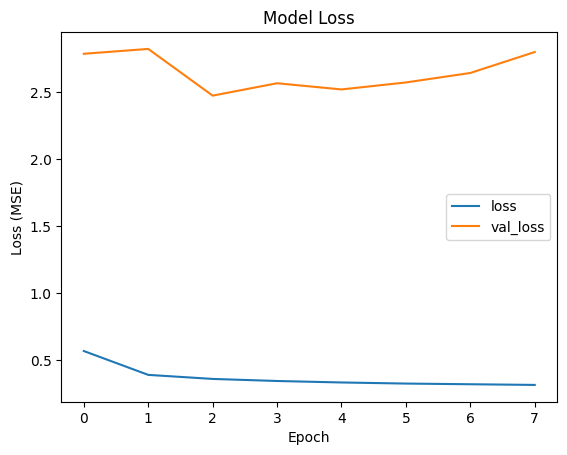

In [66]:
import matplotlib.pyplot as plt

# The 'history' object was returned by model.fit()
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Model Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.show()

In [67]:
# This will return the MSE and MAE we set up in compile()
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)

print(f"Test MSE (on log-transformed data): {test_loss}")
print(f"Test MAE (on log-transformed data): {test_mae}")

21866/21866 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 2.4721 - mean_absolute_error: 1.0527
Test MSE (on log-transformed data): 2.472114086151123
Test MAE (on log-transformed data): 1.05268394947052


In [68]:
# Make predictions on the scaled test data
predictions_scaled = model.predict(X_test_scaled)

# --- IMPORTANT: REVERSE THE LOG-TRANSFORM ---
# We used np.log1p() on y, so we use np.expm1() to reverse it.
original_y_test = np.expm1(y_test)
predicted_y = np.expm1(predictions_scaled)

# (Optional: Energy can't be negative, so clip any small negative predictions to 0)
predicted_y[predicted_y < 0] = 0

21866/21866 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step


          Actual Energy  Predicted Energy
20082536      26.249998         37.413269
20084898      26.249998         36.888607
20087261      26.249998         36.734207
20089625      26.249998         36.210411
20091987      26.249998         36.301342
20094347      26.249998         36.480812
20096708      26.249998         36.463829
20099071      26.249998         36.653759
20101434      26.249998         36.573765
20103798      25.416698         36.233696
20106161      25.416698         36.034920
20108524      25.416698         36.111855
20110886      25.416698         37.783764
20113248      25.416698         36.519321
20115610      25.416698         36.465221
20117971      25.416698         36.752747
20120330      25.416698         37.284206
20122690      25.416698         37.627934
20125050      25.416698         37.626831
20127411      25.416698         37.277542


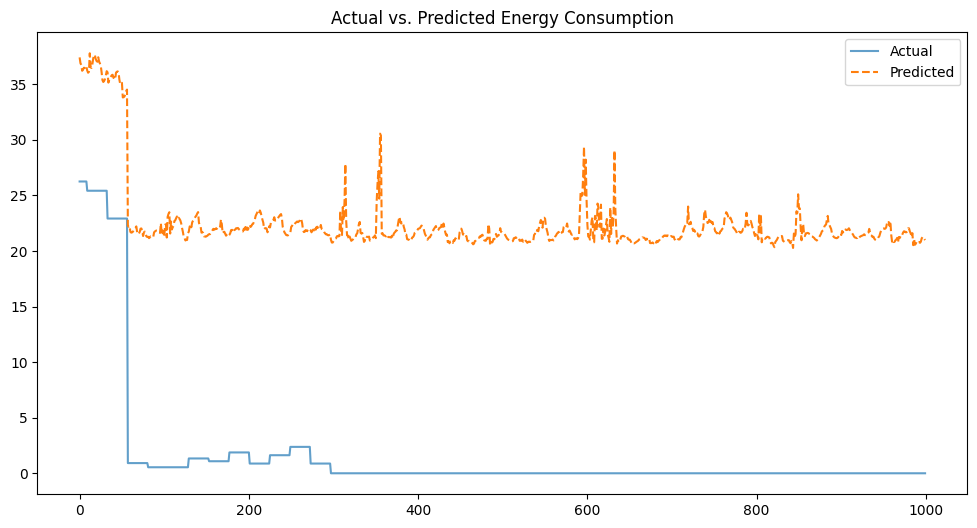

In [69]:
# Create a simple DataFrame to compare
# .flatten() is needed to turn the (N, 1) prediction array into a (N,) array
comparison_df = pd.DataFrame({
    'Actual Energy': original_y_test,
    'Predicted Energy': predicted_y.flatten()
})

# Show the first 20 predictions
print(comparison_df.head(20))

# You can also plot the actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(original_y_test.values[:1000], label='Actual', alpha=0.7) # Plot first 1000
plt.plot(predicted_y[:1000], label='Predicted', linestyle='--')
plt.title('Actual vs. Predicted Energy Consumption')
plt.legend()
plt.show()

LGBM Categorical features: ['month', 'primary_use_Education', 'primary_use_Entertainment/public assembly', 'primary_use_Food sales and service', 'primary_use_Healthcare', 'primary_use_Lodging/residential', 'primary_use_Manufacturing/industrial', 'primary_use_Office', 'primary_use_Other', 'primary_use_Parking', 'primary_use_Public services', 'primary_use_Religious worship', 'primary_use_Retail', 'primary_use_Services', 'primary_use_Technology/science', 'primary_use_Utility', 'primary_use_Warehouse/storage']
Starting LightGBM training...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2119
[LightGBM] [Info] Number of data points in the train set: 2798730, number of used features: 32
[LightGBM] [Warning] Fo

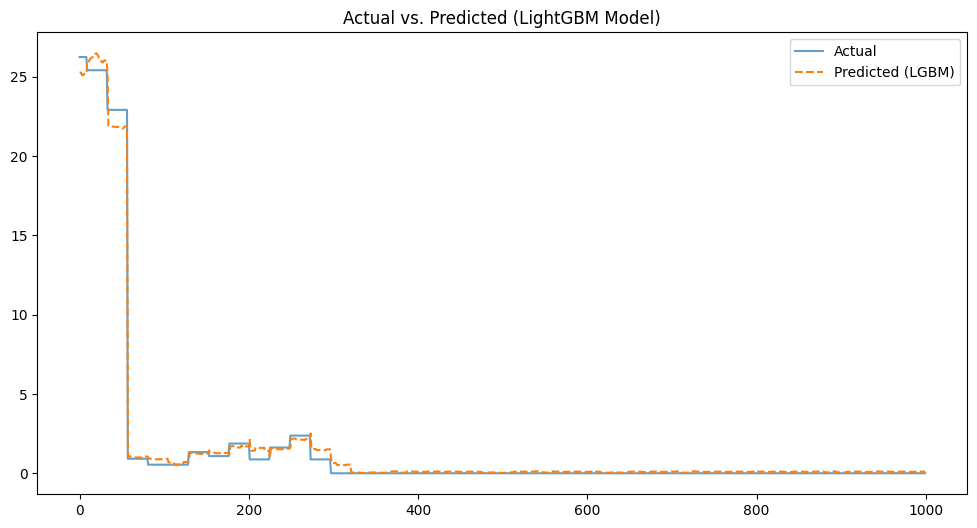

In [71]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Define Data and Categorical Features ---
# We use the *unscaled* X_train and X_test dataFrames
# y_train and y_test are still the log-transformed targets

# Find all your categorical feature names
categorical_features = ['month'] # We dropped 'hour' and 'day_of_week'

# Add the new sin/cos features (LGBM can treat them as categories or numbers)
# Let's add them as-is for now.

# Add all the one-hot encoded 'primary_use_' columns
primary_use_cols = [col for col in X_train.columns if 'primary_use_' in col]
categorical_features.extend(primary_use_cols)

print(f"LGBM Categorical features: {categorical_features}")

# --- 2. Create LightGBM Datasets ---
lgb_train = lgb.Dataset(X_train, y_train,
                        categorical_feature=categorical_features,
                        free_raw_data=False)

lgb_val = lgb.Dataset(X_test, y_test,
                      reference=lgb_train,
                      categorical_feature=categorical_features,
                      free_raw_data=False)

# --- 3. Set Parameters ---
params = {
    'objective': 'regression_l1',  # MAE is robust to outliers
    'metric': 'mae',
    'n_estimators': 2000,          # High number, but early stopping will find the best
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'seed': 42,
}

# --- 4. Train the Model ---
print("Starting LightGBM training...")

model_lgb = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[
        lgb.early_stopping(100),  # Stop after 100 rounds of no improvement
        lgb.log_evaluation(period=100)
    ]
)

print("Training finished.")

# --- 5. Evaluate the Results ---
print("Plotting LGBM predictions...")
predictions_lgb = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

# Reverse the log-transform
original_y_test = np.expm1(y_test)
predicted_y_lgb = np.expm1(predictions_lgb)
predicted_y_lgb[predicted_y_lgb < 0] = 0

# Plot the first 1000 predictions
plt.figure(figsize=(12, 6))
plt.plot(original_y_test.values[:1000], label='Actual', alpha=0.7)
plt.plot(predicted_y_lgb[:1000], label='Predicted (LGBM)', linestyle='--')
plt.title('Actual vs. Predicted (LightGBM Model)')
plt.legend()
plt.show()

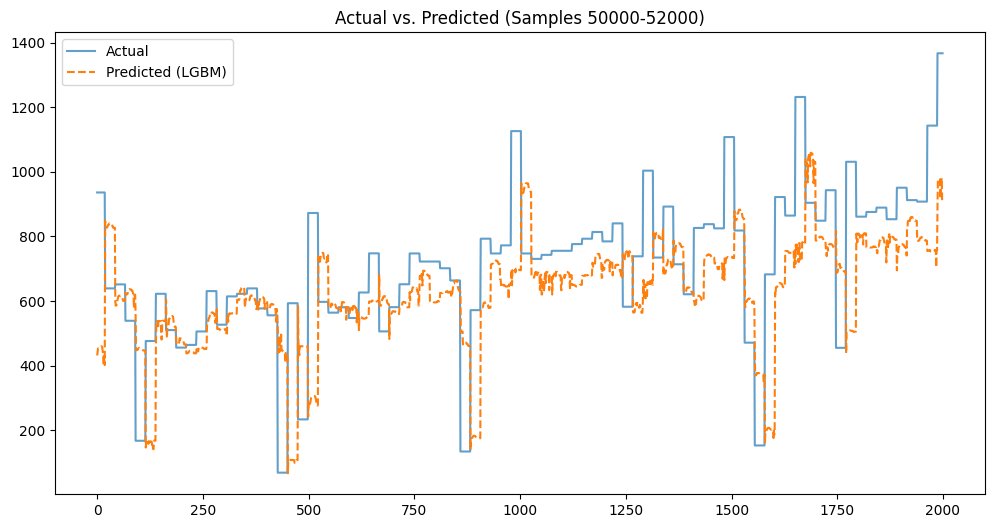

In [72]:
# --- Plot a different slice of the test data ---
# Let's plot 2000 samples, starting from sample 50,000
start_index = 50000
end_index = 52000

plt.figure(figsize=(12, 6))
plt.plot(original_y_test.values[start_index:end_index], label='Actual', alpha=0.7)
plt.plot(predicted_y_lgb[start_index:end_index], label='Predicted (LGBM)', linestyle='--')
plt.title(f'Actual vs. Predicted (Samples {start_index}-{end_index})')
plt.legend()
plt.show()

In [73]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate MAE on the *original* data
final_mae = mean_absolute_error(original_y_test, predicted_y_lgb)
print(f"Final Model MAE (on original energy scale): {final_mae:.2f}")

# Calculate R2 Score
final_r2 = r2_score(original_y_test, predicted_y_lgb)
print(f"Final Model R-squared (R2 Score): {final_r2:.4f}")

Final Model MAE (on original energy scale): 237.88
Final Model R-squared (R2 Score): 0.0363


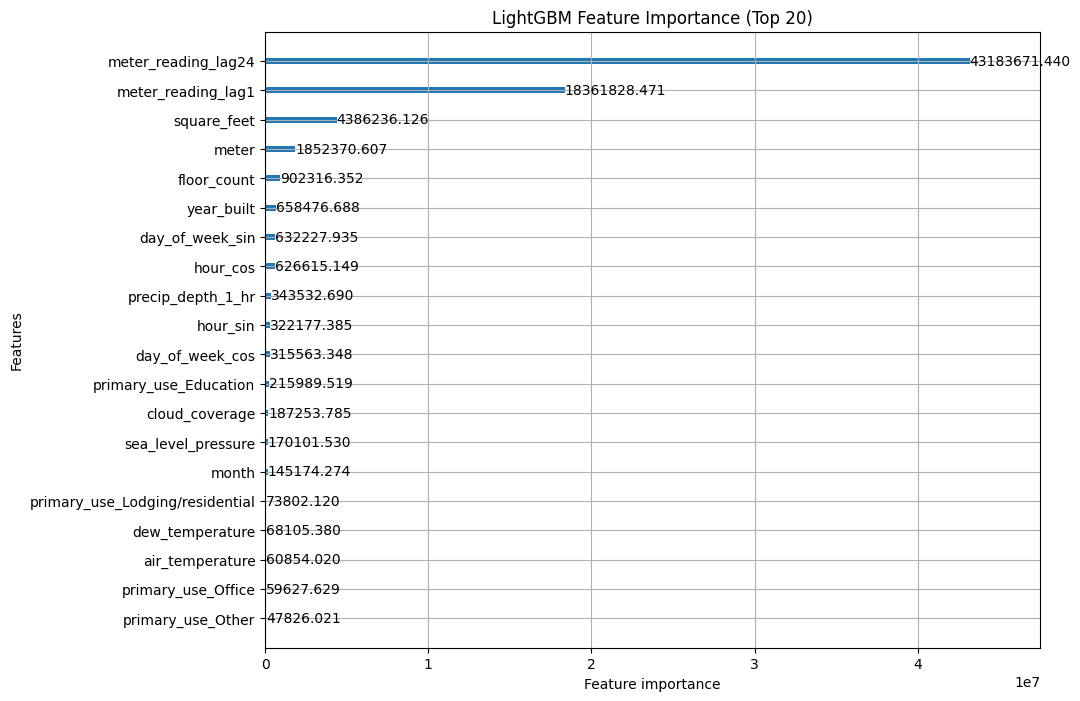

In [74]:
# Plot the top 20 most important features
lgb.plot_importance(
    model_lgb,
    figsize=(10, 8),
    max_num_features=20,
    importance_type='gain'  # 'gain' shows the total contribution to the model
)
plt.title("LightGBM Feature Importance (Top 20)")
plt.show()

In [75]:
import joblib

# --- 1. Save the LightGBM model ---
# Use the built-in save_model method, it's very efficient
model_lgb.save_model('lgbm_model.txt')

# --- 2. Save the list of feature names ---
# Your application will need to know the *exact* column order
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')

# --- 3. Save the list of categorical features ---
# The model also needs to know which features are categorical
joblib.dump(categorical_features, 'categorical_features.pkl')

print("Model and feature lists saved successfully!")

Model and feature lists saved successfully!
